The current notebook contains a Tumor Microenvironment comprehensive analysis pipeline.

**Data preparation:**

The analysis begins by reading the provided expression matrix data and performing normalization if necessary. If you intend to utilize public data and retrieve it from GEO, please refer to the [GEO_data_retrieval.ipynb](GEO_data_retrieval.ipynb) notebook for detailed instructions on data retrieval and subsequent steps.

**Quality check:**

The data preparation is followed by the Quality Check (QC), which is essential for ensuring the integrity and reliability of the data. This step involves checking for batch effects,outliers, and assessing the distribution of gene expression data to determine the quality of the dataset.

**TME classification:**

Next, the Tumor Microenvironment (TME) classification section is using the processed gene expression data from TCGA. During this step each sample is classified into one of the TME subtypes.

**de novo clusterization:**

We also have an additional section which is de novo clusterisation. It is an optional step recommended for experienced users only. This section involves the formation of a reference *signatures* cohort based on a reference *gene expression* cohort provided by the user. The resulting cohort can then be used in place of the default TCGA cohort in the TME classification section. However, it is advised to use the default cohort to ensure accurate and unbiased results during classification.

**Note:**

Furthermore, it is important to note that this notebook diligently preserves the generated plots of the dataset in the designated Plots folder, facilitating easy access and subsequent analysis of the visual outputs.

# Import of python base packages

If you have opened the current file in view-only mode but want to use the code, please go back to our repositories Setup section and follow the [instructions](https://github.com/BostonGene/MFP). 

In [1]:
%load_ext autoreload
%matplotlib inline
%config IPCompleter.use_jedi = False

import os
import pandas as pd
import numpy as np
import seaborn as sns
import pathlib
import subprocess
import logging
import csv
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

%config InlineBackend.figure_format = 'png'
plt.rcParams['pdf.fonttype'] = 'truetype'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['figure.dpi'] = 120

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from portraits.mapping import get_gs_for_probes_from_3col,get_expressions_for_gs
from portraits.plotting import *
from portraits.utils import read_gene_sets, ssgsea_formula, median_scale
from portraits.classification import KNeighborsClusterClassifier
from portraits.clustering import clustering_profile_metrics, clustering_profile_metrics_plot,clustering_select_best_tr

In [4]:
%load_ext rpy2.ipython

If you already have RNA-Seq data insert your data path in EXPRESSION_MATRIX and skip to the QC section.

In [5]:
#Constants

EXPRESSION_MATRIX = 'Cohorts/TCGA_input_expressions/expressions.tsv.gz'
TCGA_SIGNATURES = 'Cohorts/Pan_TCGA/signatures.tsv'
TCGA_COHORTS_ANNOTATION = 'Cohorts/Pan_TCGA/annotation.tsv'
CLASSIFIED_SAMPLES = 'classified_samples.tsv'
GENE_SIGNATURES = 'signatures/gene_signatures.gmt'

Creating a Plots direcotry to save all of the generated plots.

In [6]:
if not os.path.exists('Plots'):
    os.mkdir('Plots')

# Data preparation

If you have your own RNA-SEQ data change the EXPRESSION_MATRIX value into your expression matrix file path.If you want to retriev your data from GEO go to the [GEO_data_retrieval.ipynb](GEO_data_retrieval.ipynb) notebook and after finishing the RNA-Seq data generation change the EXPRESSION_MATRIX into that file path.

In [7]:
annotated_expression = pd.read_csv(EXPRESSION_MATRIX, sep='\t', index_col=0)

In [8]:
annotated_expression.shape

(20062, 412)

In [9]:
annotated_expression.head()

,TCGA-GC-A6I3-11,TCGA-XF-A9SU-01,TCGA-DK-AA6R-01,TCGA-E7-A677-01,TCGA-FD-A6TG-01,TCGA-CF-A47Y-01,TCGA-G2-AA3D-01,TCGA-BT-A20J-01,TCGA-DK-A6AV-01,TCGA-XF-A8HE-01,...,TCGA-FD-A3N5-01,TCGA-FD-A6TH-01,TCGA-GV-A3JZ-01,TCGA-XF-A8HD-01,TCGA-XF-AAMX-01,TCGA-DK-AA6S-01,TCGA-XF-AAML-01,TCGA-CF-A47T-01,TCGA-CF-A47V-01,TCGA-FJ-A3ZF-01
Gene,,,,,,,,,,,,,,,,,,,,,
A1BG,0.000000,0.000000,0.000000,0.129864,0.000000,0.000000,0.000000,0.047855,0.809440,0.000000,...,0.000000,0.341834,0.057845,0.000000,0.000000,0.000000,0.000000,0.000000,0.079626,0.000000
A1CF,0.043268,0.010951,0.042670,0.292750,0.064640,0.023515,0.100593,0.000000,0.103161,0.038620,...,0.025097,0.051144,0.088083,0.040883,0.092098,0.030296,0.036765,0.040774,0.075111,0.252180
A2M,8.481033,7.640422,5.482871,6.631318,9.314429,6.744841,5.226542,6.510175,6.532254,5.945897,...,5.099326,6.660468,7.655823,6.841096,7.037324,7.532450,4.212960,5.634424,8.098234,5.122270
A2ML1,1.010844,1.710115,6.416485,0.847016,5.065935,0.280278,4.869122,4.156480,4.905806,5.310285,...,6.998299,5.412907,4.811520,0.372405,4.078089,5.253520,5.570708,0.788623,2.021385,4.371655
A3GALT2,0.123756,0.000000,0.053872,0.177503,0.000000,0.193011,0.130660,0.000000,0.219909,0.106140,...,0.000000,0.000000,0.171876,0.000000,0.075635,0.150974,0.149240,0.088675,0.107569,0.178381


Check if expression matrix is normalized if not log2 transform it.

In [10]:
if all(0<=sample<=18 for sample in annotated_expression.mean()):
    print(annotated_expression.head())
else:
    annotated_expression = np.log2(1+annotated_expression)
    print(annotated_expression.head())

         TCGA-GC-A6I3-11  TCGA-XF-A9SU-01  TCGA-DK-AA6R-01  TCGA-E7-A677-01  \
Gene                                                                          
A1BG            0.000000         0.000000         0.000000         0.129864   
A1CF            0.043268         0.010951         0.042670         0.292750   
A2M             8.481033         7.640422         5.482871         6.631318   
A2ML1           1.010844         1.710115         6.416485         0.847016   
A3GALT2         0.123756         0.000000         0.053872         0.177503   

         TCGA-FD-A6TG-01  TCGA-CF-A47Y-01  TCGA-G2-AA3D-01  TCGA-BT-A20J-01  \
Gene                                                                          
A1BG            0.000000         0.000000         0.000000         0.047855   
A1CF            0.064640         0.023515         0.100593         0.000000   
A2M             9.314429         6.744841         5.226542         6.510175   
A2ML1           5.065935         0.280278         4

# Quality check (QC)

**Please note that all examples, illustrations and plots are applicable solely within the context of RNA-Seq datasets.**

The Quality Check (QC) section identifies batches, outliers, and assesses the expression data distribution using PCA plot, UMAP plot, distribution plot, or other techniques.


We will provide examples of both bad and good datasets, which will help you differentiate them visually and understand the types of possible data quality issues that may affect downstream analyses.

## Batch detection

This section is responsible for identifying any potential batch effects in the analyzed data using UMAP and PCA analyses. The results of these analyses are plotted to visualize any potential batches in the data.

If you are not familiar with batch effects follow [this link.](https://towardsdatascience.com/batcheffectsc71c886ca9c5) 

### Batche detection by UMAP

Here is an example of a sample check results for the presence of batch effects using the UMAP analysis. Two plots have been generated to visualize possible analysis results. The plot on the right shows an example of a dataset with no identified issues, whereas the plot on the left exhibits potential batch effects.

You can see that the plot on the left shows two distinct clusters of data points that are grouped quite far from each other. This is indicative of the presence of a potential batch effect.

If your data plot resembles the one on the left, remove any identified batch effects to ensure accurate and reliable results.

[Here are the instructions for batch effect removal](https://github.com/chichaumiau/removeBatcheffect)

![Umap Example](plots/umap_examples.svg)

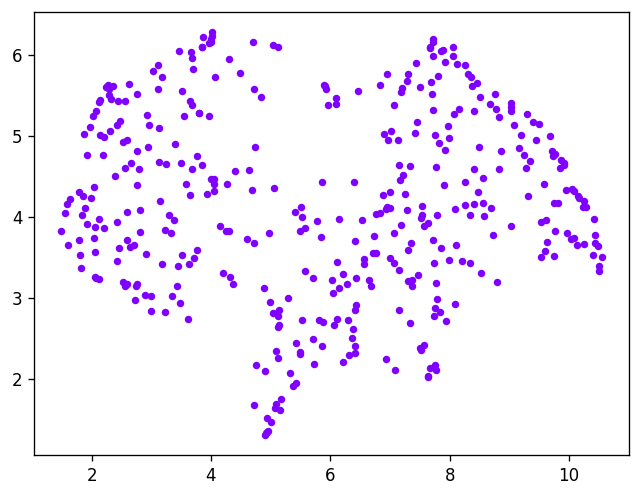

In [11]:
# Generate umap_plot for the input data
fig_umap, axes_umap = plt.subplots()

umap_plot(annotated_expression.T, legend = 'Out',ax = axes_umap)

# Saving the generated umap plot into a picture.
fig_umap.savefig('Plots/umap_batches.svg')

### Batch detection by PCA

To further enhance the significance of our analysis, we additionally perform the PCA analysis and plot the results to ensure that our data is free from any batch effects.

Below is an example of a sample check results for the presence of batch effects. Again, two plots have been generated to visualize possible analysis results.  Batch effects in the plot on the left can be suggested from the presence of two distinct groups of data points that appear far from each other. In contrast, a normal dataset appears as a single group of data points that are relatively close to each other, as reflected in the PCA plot.

This step is essential to ensure that (a) the data used is free from any systematic variation that could confound the analyses and (b) any observed effects are biologically meaningful.

![Pca batches example not colored](plots/pca_batches_example_colored.svg)

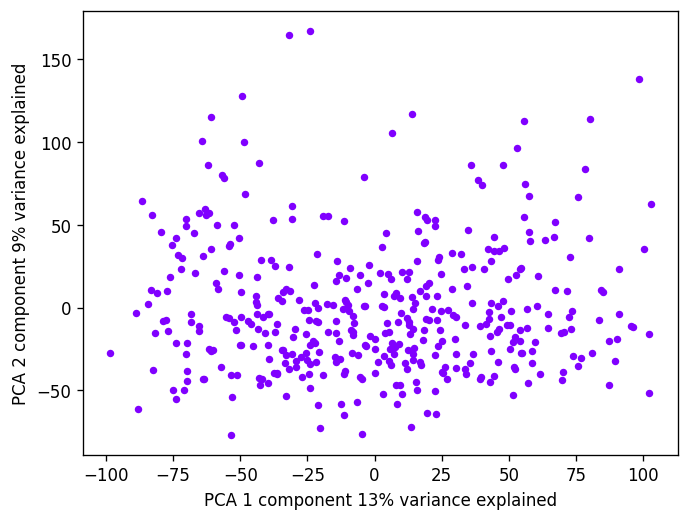

In [12]:
# Generate the pca plot for the annotated_expressions

fig_pca_batches, ax_pca_batches = plt.subplots()

pca_plot(annotated_expression.T, legend = None,ax = ax_pca_batches)

# Save the generated pca plot into a picture.
fig_pca_batches.savefig('Plots/pca_batches.svg')

## Outlier detection

The purpose of this section is to identify outliers in the annotated_expression data through PCA analysis and the generation of corresponding plots.

Below is an illustrative example of data outliers.
In the plot on the left, two points lie far away from the main group of data points, indicating the presence of outliers in the dataset. In contrast, the data points in the plot on the right lie relatively close to each other, with no outliers detected.

To get detailed information on data outliers, follow this [link](https://www.geeksforgeeks.org/detect-and-remove-the-outliers-using-python/)

![PCA outliers example](plots/pca_outliers_example.svg)

The code cell below generates a PCA plot of the transposed annotated_expression data. Transposing the data allows the sample IDs to be located in the row positions, which facilitates dimension reduction based on samples. This plot can help identify any possible data outliers.

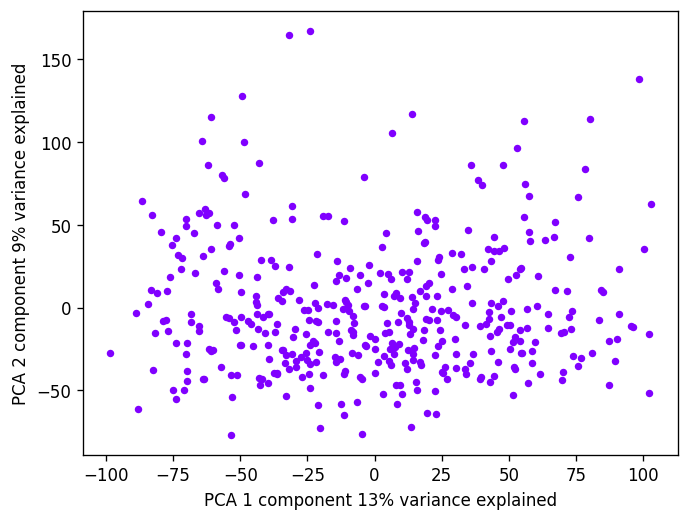

In [13]:
# Generate pca plot for annotated_expression to find outliers

fig_pca_outliers,ax_pca_outliers = plt.subplots()

pca_plot(annotated_expression.T, legend= None, ax= ax_pca_outliers)

# Save the generated pca plot into a picture.
fig_pca_outliers.savefig('Plots/pca_outliers.svg')

If the pca_plot of your data suggests the analyzed data contain outliers, remove the outlying points from your dataset.

In [14]:
# Check for repetitive sample ids 
annotated_expression.columns.value_counts().max()

1

## Data distribution check

Data distribution check

This is the final section of the QC, where data quality is checked based on its distribution.

As with the previous sections, an example of two gene expression datasets is provided below, with one exhibiting a good-quality dataset and the other exhibiting a poor-quality dataset, as indicated by their respective distribution plots.

In the plot on the right, the expression values start off very low and then rise before dropping down. This pattern suggests potential RNA degradation, which can compromise the reliability and accuracy of downstream analyses. In contrast, the distribution plot on the left shows good-quality gene expression data.
Deviations from such distributions may indicate gene degradation, should be carefully investigated and, if necessary, corrected to ensure high-quality data.

If your data plot shows distribution of a good quality data, you can proceed with the analyses. If it resembles the one on the right, then your data is probably abnormal and might have RNA degradation. In the case of RNA degradation,  do not proceed with the analyses and choose a new dataset.

![Data distribution example](plots/distribution_example.svg)

The code snippet provided generates a visualization of the distribution of annotated expression values. This type of data visualization is useful for identifying trends and patterns in gene expression data and can aid in the quality control and preprocessing of the data.

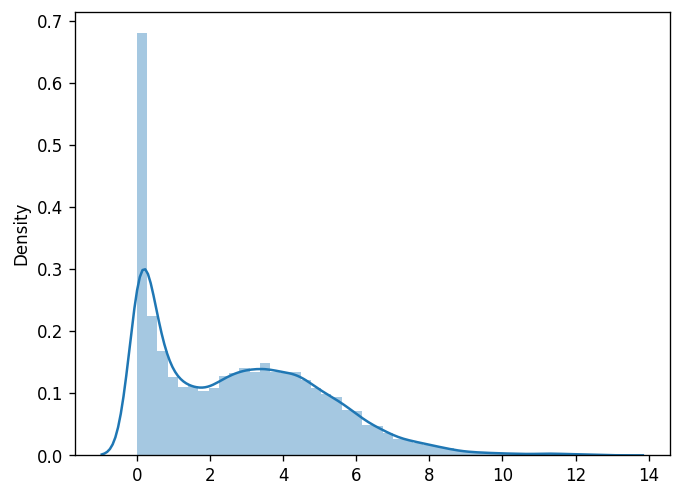

In [15]:
# Generating distribution plot

fig_dist, ax_dist = plt.subplots()

sns.distplot(annotated_expression.mean(axis=1), kde = True)

#Save the generated distribution plot into a picture
fig_dist.savefig('Plots/distribution.svg')

If you have successfully passed all of the QC tests, you can move to the TME classification step. If there are any data issues, fix them before proceeding to the next step as they can affect the results of the analyses.

In [16]:
#Print the dataframe to know how it looks in table form 
annotated_expression.head()

,TCGA-GC-A6I3-11,TCGA-XF-A9SU-01,TCGA-DK-AA6R-01,TCGA-E7-A677-01,TCGA-FD-A6TG-01,TCGA-CF-A47Y-01,TCGA-G2-AA3D-01,TCGA-BT-A20J-01,TCGA-DK-A6AV-01,TCGA-XF-A8HE-01,...,TCGA-FD-A3N5-01,TCGA-FD-A6TH-01,TCGA-GV-A3JZ-01,TCGA-XF-A8HD-01,TCGA-XF-AAMX-01,TCGA-DK-AA6S-01,TCGA-XF-AAML-01,TCGA-CF-A47T-01,TCGA-CF-A47V-01,TCGA-FJ-A3ZF-01
Gene,,,,,,,,,,,,,,,,,,,,,
A1BG,0.000000,0.000000,0.000000,0.129864,0.000000,0.000000,0.000000,0.047855,0.809440,0.000000,...,0.000000,0.341834,0.057845,0.000000,0.000000,0.000000,0.000000,0.000000,0.079626,0.000000
A1CF,0.043268,0.010951,0.042670,0.292750,0.064640,0.023515,0.100593,0.000000,0.103161,0.038620,...,0.025097,0.051144,0.088083,0.040883,0.092098,0.030296,0.036765,0.040774,0.075111,0.252180
A2M,8.481033,7.640422,5.482871,6.631318,9.314429,6.744841,5.226542,6.510175,6.532254,5.945897,...,5.099326,6.660468,7.655823,6.841096,7.037324,7.532450,4.212960,5.634424,8.098234,5.122270
A2ML1,1.010844,1.710115,6.416485,0.847016,5.065935,0.280278,4.869122,4.156480,4.905806,5.310285,...,6.998299,5.412907,4.811520,0.372405,4.078089,5.253520,5.570708,0.788623,2.021385,4.371655
A3GALT2,0.123756,0.000000,0.053872,0.177503,0.000000,0.193011,0.130660,0.000000,0.219909,0.106140,...,0.000000,0.000000,0.171876,0.000000,0.075635,0.150974,0.149240,0.088675,0.107569,0.178381


# TME classification

The classification section determines each sample subtype against the reference TCGA cohort. The TCGA cohort was split into clusters using KNeighborsClusterClassifier. The resulting clusters are stored as a MODEL variable, with each cluster belonging to a different subtype. Then the samples EXPRESSION_MATRIX and GENE_SIGNATURES files are read and passed to the ssgsea_formula function to determine each signature (columns) score for every sample (rows).

## Load Reference Cohort with known TME labels and gene expression values


Load the TCGA cohort

In [17]:
TCGA_signature_scores_scaled = pd.read_csv(TCGA_SIGNATURES, sep='\t', index_col=0)  # Signatures in rows
print(f'Reference signatures provided for {len(TCGA_signature_scores_scaled)} samples')

TCGA_annotation = pd.read_csv(TCGA_COHORTS_ANNOTATION, sep='\t', index_col=0)  # Contains MFP cluster labels in MFP column
print(f'Reference annotation provided for {len(TCGA_signature_scores_scaled)} samples')

Reference signatures provided for 29 samples
Reference annotation provided for 29 samples


In [18]:
TCGA_signature_scores_scaled.shape

(29, 8024)

In [19]:
TCGA_signature_scores_scaled.head()

,TCGA-OR-A5J1,TCGA-OR-A5J2,TCGA-OR-A5J3,TCGA-OR-A5J5,TCGA-OR-A5J6,TCGA-OR-A5J7,TCGA-OR-A5J8,TCGA-OR-A5J9,TCGA-OR-A5JA,TCGA-OR-A5JB,...,TCGA-WC-A885,TCGA-WC-A888,TCGA-WC-A88A,TCGA-WC-AA9A,TCGA-WC-AA9E,TCGA-YZ-A980,TCGA-YZ-A982,TCGA-YZ-A983,TCGA-YZ-A984,TCGA-YZ-A985
Angiogenesis,-0.661531,1.583381,0.267748,-2.647846,-0.071126,1.362581,2.838784,2.524522,-0.402077,-1.257830,...,-1.574175,-1.307615,1.649727,-1.279347,-1.740467,1.294947,-1.316592,-0.879181,2.475212,0.113487
Endothelium,-0.474094,1.424070,-1.519066,-2.290573,1.212545,1.006049,-0.009537,1.579478,-1.519467,-2.714505,...,-1.287016,-0.667840,1.465586,-2.173068,-1.552286,1.606122,0.037654,-0.240127,2.836803,0.293002
CAF,-1.747577,0.954718,-0.533190,-0.559493,-1.912118,-0.273307,4.000000,-0.430856,0.203419,1.195279,...,-0.673280,-0.344506,0.807490,-2.668342,-1.404025,0.623299,0.301762,-1.820833,1.391151,0.196909
Matrix,-2.182482,0.165168,-0.546502,-0.956463,-2.032676,0.233766,2.127843,-0.855926,0.426424,0.729188,...,-1.303162,-0.453696,1.447741,-2.233778,-0.981243,0.939589,-0.988046,-1.742297,0.800888,0.559041
Matrix_remodeling,-1.236812,-0.229481,2.180185,0.133336,-1.325297,-1.288253,4.000000,-0.874358,1.693402,3.615724,...,0.726274,1.286900,1.821143,-0.393247,-0.566016,-0.328423,1.236542,-0.442878,0.397429,0.236518


In [24]:
TCGA_annotation.MFP

TCGA-OR-A5J1    IE
TCGA-OR-A5J2     F
TCGA-OR-A5J3     D
TCGA-OR-A5J5     D
TCGA-OR-A5J6    IE
                ..
TCGA-YZ-A980     F
TCGA-YZ-A982     D
TCGA-YZ-A983    IE
TCGA-YZ-A984     F
TCGA-YZ-A985     D
Name: MFP, Length: 8024, dtype: object

In [27]:
# Fit the model
MODEL = KNeighborsClusterClassifier(norm=False, scale=False, clip=2, k=35).fit(TCGA_signature_scores_scaled.T,
                                                                               TCGA_annotation.MFP)

# Read signatures
gene_signatures = read_gene_sets(GENE_SIGNATURES)  # GMT format like in MSIGdb
print(f'Loaded {len(gene_signatures)} signatures')

gene_expressions = annotated_expression.T

print(f'Classifying cohort, N={len(gene_expressions)} samples')

if annotated_expression.max().max() > 35:
    print('Performing log2+1 transformation')
    gene_expressions = np.log2(1+gene_expressions)
    

Loaded 29 signatures
Classifying cohort, N=412 samples


## Classify the input cohort and give the output .tsv file with the TME subtype for each sample

The codeblock establishes to which subtype each sample belongs and then prints out the number of samples that have the given subtype. The CLASSIFIED_SAMPLES file is given as an output. It lists the subtypes of all analyzed samples.


In [28]:
# Calc signature scores
signature_scores = ssgsea_formula(gene_expressions, gene_signatures)

# Scale signatures
signature_scores_scaled = median_scale(signature_scores)

In [29]:
signature_scores_scaled

,MHCI,MHCII,Coactivation_molecules,Effector_cells,T_cell_traffic,NK_cells,T_cells,B_cells,M1_signatures,Th1_signature,...,Macrophage_DC_traffic,Th2_signature,Protumor_cytokines,CAF,Matrix,Matrix_remodeling,Angiogenesis,Endothelium,Proliferation_rate,EMT_signature
TCGA-GC-A6I3-11,0.083432,0.987001,3.880472,2.214178,0.515701,1.904412,2.628548,5.926074,1.286390,1.917477,...,0.634968,3.018433,1.924009,0.345046,-0.438335,0.428441,1.561478,2.147181,-0.289973,1.923373
TCGA-XF-A9SU-01,-1.638832,0.048784,0.501064,0.485459,0.470731,0.058196,0.797727,1.439240,0.539672,-0.031413,...,0.461279,-0.951095,1.158496,0.771374,0.707412,1.041234,0.072101,0.383419,0.230943,1.216322
TCGA-DK-AA6R-01,1.427933,-1.303327,-0.594217,0.735304,1.246757,1.079800,-0.200940,-0.564154,0.384611,1.748115,...,0.211941,-0.113098,0.719381,0.093255,1.392075,1.296230,0.800060,-0.533786,1.246761,0.358953
TCGA-E7-A677-01,0.138957,-0.185318,0.575455,-0.422677,0.456692,-0.702405,0.237396,-0.522376,1.219193,0.209528,...,-0.181841,-0.252897,-0.576956,-0.851821,0.234857,1.030135,1.385839,-0.400100,-1.308200,-1.105099
TCGA-FD-A6TG-01,-1.021296,0.560027,0.060357,0.000614,0.422613,-0.230438,0.404963,1.434768,-1.544670,-0.479280,...,-0.111018,-0.819020,-0.295109,1.116390,0.535043,-0.709582,-0.452178,1.313575,-0.432566,0.060087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-DK-AA6S-01,0.100991,0.475857,1.694719,0.959426,1.628925,0.717893,1.187814,-0.418315,0.837877,1.033217,...,1.016955,0.077062,0.682019,1.404819,1.567829,1.393206,-0.124382,0.129157,-1.008648,1.589557
TCGA-XF-AAML-01,0.750204,1.353378,0.070554,0.375419,0.186281,0.285539,0.327568,0.069531,1.662492,0.076728,...,-0.649170,1.072400,-2.625274,-2.775018,-2.512470,-0.566286,-1.117642,-2.252652,0.927154,-2.325626
TCGA-CF-A47T-01,-2.481960,-4.093203,-1.493529,-1.178818,-1.930647,-1.070651,-0.406238,-0.488519,-1.648872,-0.053151,...,-1.415570,-1.343194,-0.930407,-0.821733,-0.442407,0.160178,-0.329086,0.455860,0.065047,-0.566958
TCGA-CF-A47V-01,0.308607,-0.463626,-0.426327,-0.405471,-0.218716,0.611788,0.371019,-0.200971,0.605977,-0.644371,...,-0.614654,-1.606622,-0.638670,-0.843019,-0.180910,-0.807858,2.396344,2.780989,-2.409978,-0.248718


In [30]:
# Predict clusters
classified_samples = MODEL.predict(signature_scores_scaled[MODEL.X.columns].dropna()).rename('TME')

#Output the predicted clusters
print('Predicted labels count:')
print(classified_samples.value_counts())

# Output the classified samples table
classified_samples.to_csv(CLASSIFIED_SAMPLES, sep='\t', index=True)

Predicted labels count:
D       173
IE       98
F        74
IE/F     67
Name: TME, dtype: int64


### Visalize classified data

The code provided below generates several plots to make the data visualisation easier and to help you understand the differences betweeen signatures.

In [31]:
classified_samples = pd.read_csv(CLASSIFIED_SAMPLES, sep='\t', index_col=0)

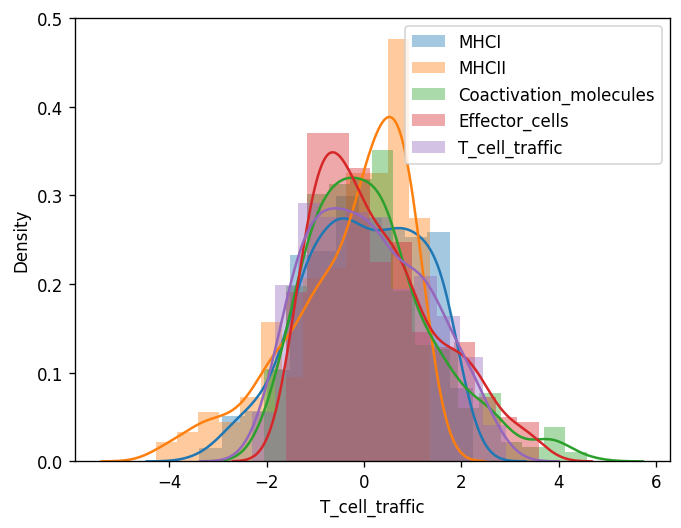

In [32]:
# genere distribution plots for already scaled signature values

fig, ax = plt.subplots(1, 1)
for i in signature_scores_scaled.columns[:5]:
    sns.distplot(signature_scores_scaled[i], label=i, ax=ax, kde=True)
ax.legend()

# Savie the generated distribution plots into a picture.
fig.savefig('Plots/scaled_data_distribution.svg')

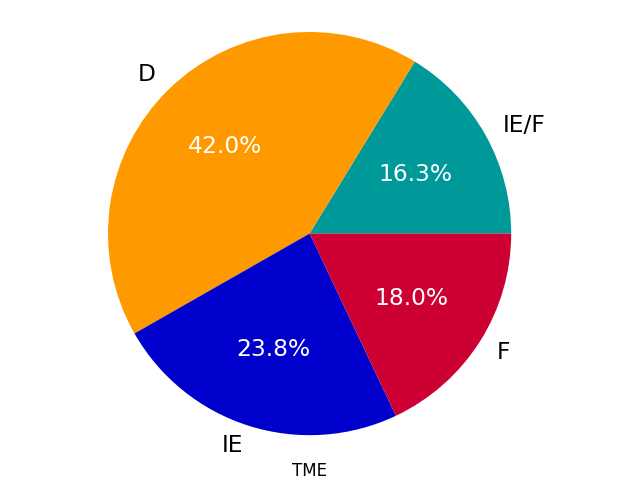

In [33]:
tme_palette = {"IE": '#0000CC', "IE/F": '#009999', "F": '#CC0033', "D": '#FF9900'}

fig_pie_plot, ax_pie_plot = plt.subplots()

vector_pie_plot(classified_samples.squeeze(),palette=tme_palette, ax= ax_pie_plot)

# Save the generated pie plot into a picture.
fig_pie_plot.savefig('Plots/classified_samples_percentage.svg')

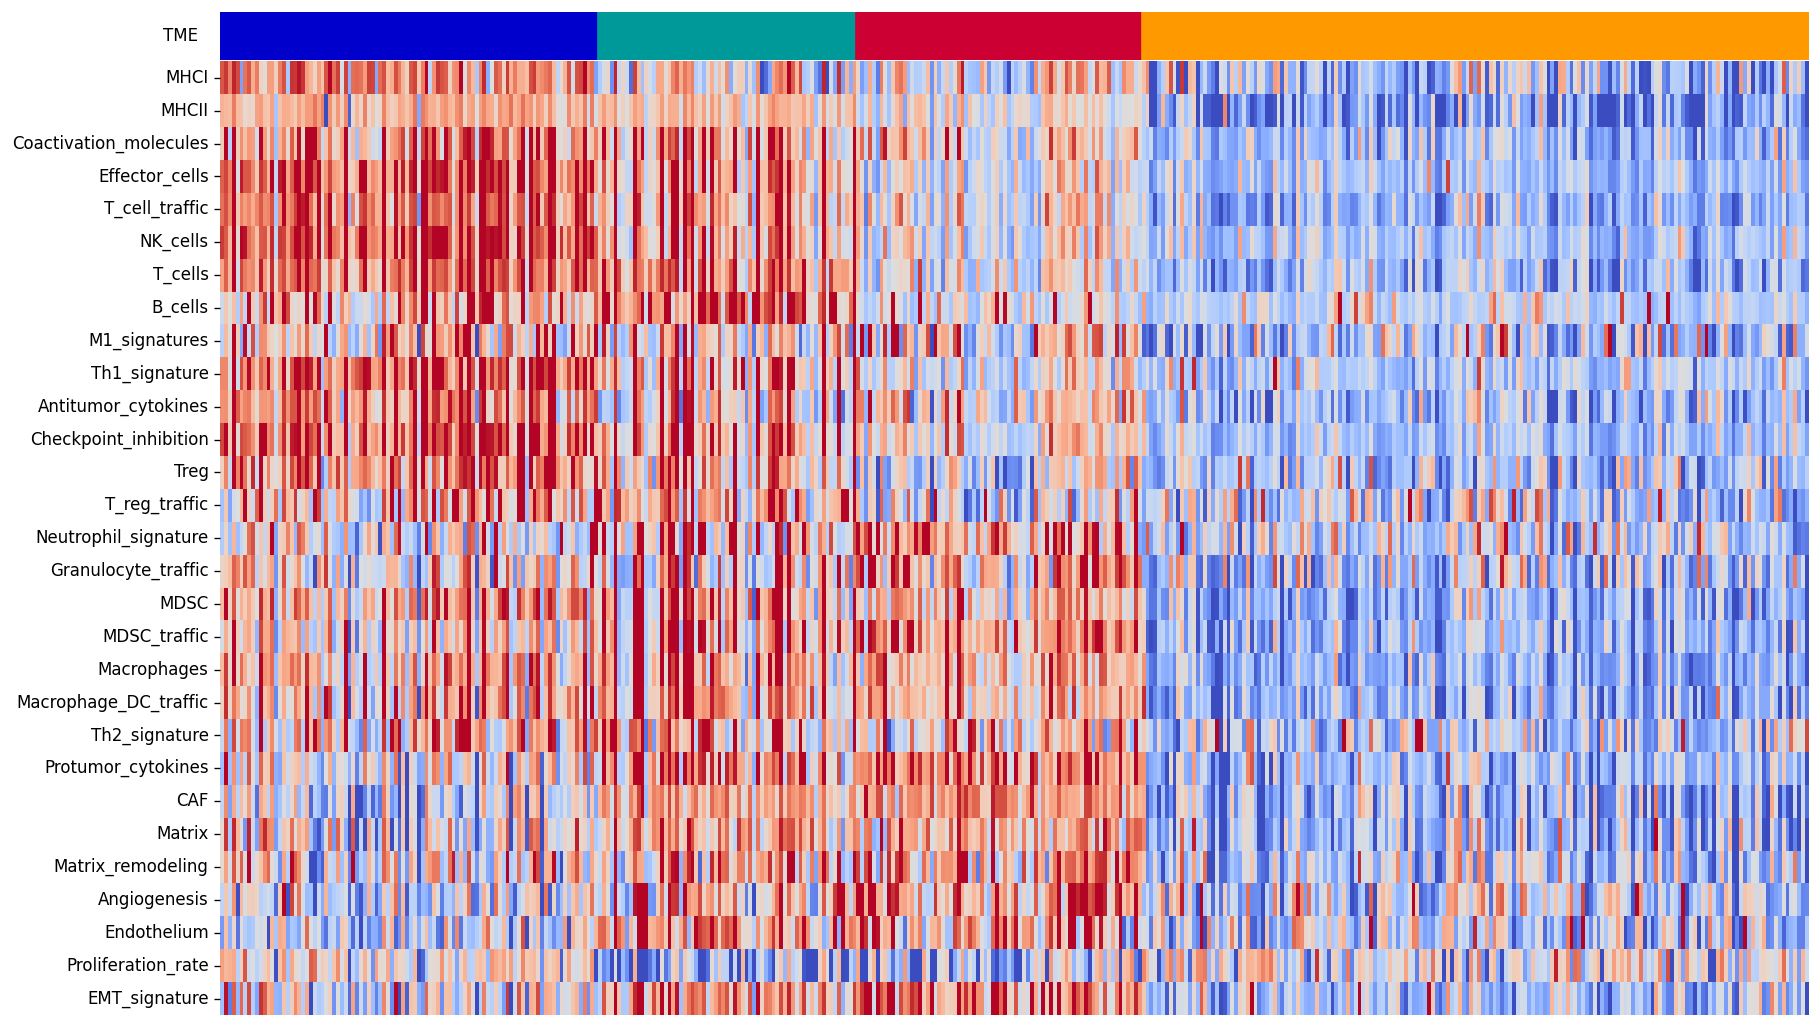

In [34]:
af = axis_matras([.4, 8], x_len=15)
ax=next(af)

order = ["IE", "IE/F", "F", "D"]

ordered_classified_samples = pd.read_csv(CLASSIFIED_SAMPLES, sep='\t')

ordered_classified_samples['TME'] = pd.Categorical(ordered_classified_samples['TME'], categories=order, ordered=True)

ordered_classified_samples = ordered_classified_samples.sort_values('TME')

classified_samples = pd.Series(classified_samples.squeeze())

line_palette_annotation_plot(classified_samples[ordered_classified_samples.iloc[:,0]], ax=ax, palette=tme_palette)

ax = next(af)
sns.heatmap(signature_scores_scaled.loc[ ordered_classified_samples.iloc[:,0],gene_signatures].clip(-2, 2).T,
            yticklabels=True, xticklabels=False, cbar=False, cmap=plt.cm.coolwarm,ax=ax)
plt.tight_layout(pad=.1)

# Save the generated heatmap plot into a picture.
ax.figure.savefig('Plots/signatures_heatmap.svg')

# de novo clusterization

This section helps to create your own reference cohort for further classification.

## Calculate signature scores of reference gene expression values

Insert the path to your reference cohort file into the REFERENCE_EXPRESSION.

In [35]:
#constants
REFERENCE_EXPRESSION = EXPRESSION_MATRIX
DENOVO_REFRENCE_COHORT = 'samples_subtyping_by_tme.tsv'

In [36]:
# Example script

# Read signatures
gmt = read_gene_sets(GENE_SIGNATURES)  # GMT format like in MSIGdb


# Read expressions
exp = pd.read_csv(REFERENCE_EXPRESSION, sep='\t', index_col = 0).T  # log2+1 transformed; Genes in columns

# Calc signature scores
signature_scores = ssgsea_formula(exp, gmt)

# Scale signatures
signature_scores_scaled = median_scale(signature_scores)

signature_scores_scaled.head()

,MHCI,MHCII,Coactivation_molecules,Effector_cells,T_cell_traffic,NK_cells,T_cells,B_cells,M1_signatures,Th1_signature,...,Macrophage_DC_traffic,Th2_signature,Protumor_cytokines,CAF,Matrix,Matrix_remodeling,Angiogenesis,Endothelium,Proliferation_rate,EMT_signature
TCGA-GC-A6I3-11,0.083432,0.987001,3.880472,2.214178,0.515701,1.904412,2.628548,5.926074,1.286390,1.917477,...,0.634968,3.018433,1.924009,0.345046,-0.438335,0.428441,1.561478,2.147181,-0.289973,1.923373
TCGA-XF-A9SU-01,-1.638832,0.048784,0.501064,0.485459,0.470731,0.058196,0.797727,1.439240,0.539672,-0.031413,...,0.461279,-0.951095,1.158496,0.771374,0.707412,1.041234,0.072101,0.383419,0.230943,1.216322
TCGA-DK-AA6R-01,1.427933,-1.303327,-0.594217,0.735304,1.246757,1.079800,-0.200940,-0.564154,0.384611,1.748115,...,0.211941,-0.113098,0.719381,0.093255,1.392075,1.296230,0.800060,-0.533786,1.246761,0.358953
TCGA-E7-A677-01,0.138957,-0.185318,0.575455,-0.422677,0.456692,-0.702405,0.237396,-0.522376,1.219193,0.209528,...,-0.181841,-0.252897,-0.576956,-0.851821,0.234857,1.030135,1.385839,-0.400100,-1.308200,-1.105099
TCGA-FD-A6TG-01,-1.021296,0.560027,0.060357,0.000614,0.422613,-0.230438,0.404963,1.434768,-1.544670,-0.479280,...,-0.111018,-0.819020,-0.295109,1.116390,0.535043,-0.709582,-0.452178,1.313575,-0.432566,0.060087


## Visualize clusters according to the selected threshold and statistical scores of correlation between data values


The clusterization is done using the clustering_profile_metrics function from the clustering.py library. The calculations are done using Davies Bouldin, Calinski Harabasz, Silouhette scores to get the correlation between clusters and each ssGSEA score data point.

For more information on the mentioned calculations and correlation scores, follow [this link](https://medium.com/@haataa/how-to-measure-clustering-performances-when-there-are-no-ground-truth-db027e9a871c)

Check the clustering within a range of 30% to 65% similarity
- \>65% - means no correlation between data points in the graph
- <30% - means a false positive correlation

100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.17it/s]


<Axes: ylabel='Cluster %'>

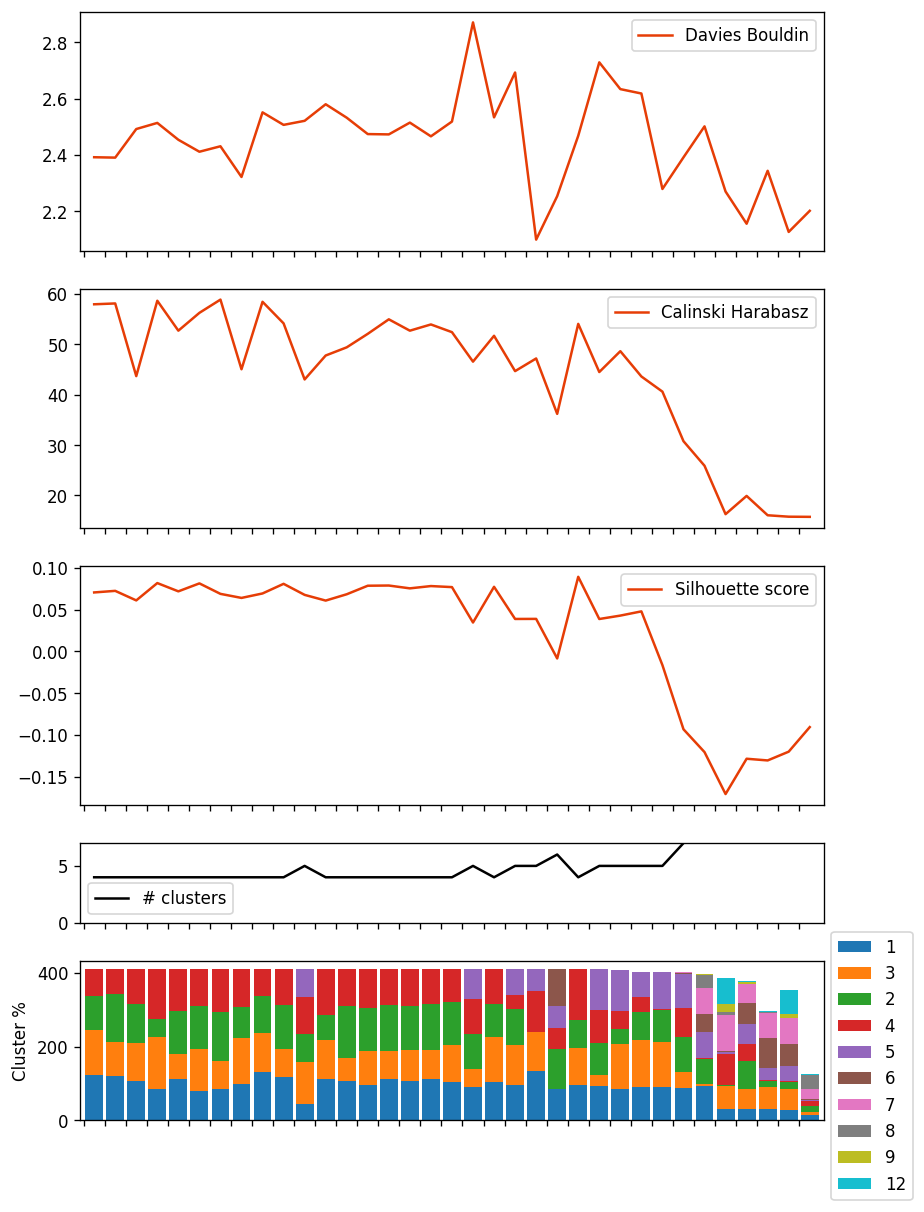

In [37]:
clustering_metrics = clustering_profile_metrics(signature_scores_scaled, threshold_mm=(.3, .65), step=.01)

# Visualize the partitions
clustering_profile_metrics_plot(clustering_metrics)

The plot above shows the count of clusters and their size for each threshold.

## Classify each cluster/sample into a TME subtype 

In [38]:
def detect_type(clustering_metrics: pd.DataFrame,scores: pd.DataFrame) -> pd.Series:

    clusters_number = clustering_metrics.loc['N'] 

    # samples_clustering is a pd.Series with patients as indexes and their clusters as values
    samples_clustering = clustering_metrics.loc['perc']
    cluster_means = pd.DataFrame({cluster: scores.loc[samples_clustering[samples_clustering == cluster].index].mean()
                                  for cluster in range(1, clusters_number + 1)})

    deltas = (cluster_means.loc[['Angiogenesis', 'Endothelium', 'CAF', 'Matrix', 'Matrix_remodeling']].mean() -
              cluster_means.loc[['MHCII', 'Antitumor_cytokines', 'Coactivation_molecules',
                          'B_cells', 'NK_cells', 'Checkpoint_inhibition',
                          'Effector_cells', 'T_cells', 'Th1_signature',
                          'T_cell_traffic', 'MHCI']].mean()).sort_values()

    mapper = {}
    mapper[deltas.index[-1]] = 'F'  # The cluster with the highest fibrose value is classified as Fibrotic
    mapper[deltas.index[0]] = 'IE'  # Thecluster with the highest level of immune cells is classified as 
                                    # Immune enriched, non-fibrotic

    # Remove detected clusters
    cluster_means.pop(deltas.index[-1])
    cluster_means.pop(deltas.index[0])

    deltas = (cluster_means.loc[['Angiogenesis', 'Endothelium', 'CAF', 'Matrix', 'Matrix_remodeling',
                          'Protumor_cytokines', 'Neutrophil_signature', 'Granulocyte_traffic',
                          'Macrophages', 'Macrophage_DC_traffic', 'MDSC_traffic', 'MDSC',
                          'Th2_signature', 'T_reg_traffic', 'Treg', 'M1_signatures', 'MHCII',
                          'Antitumor_cytokines', 'Coactivation_molecules', 'B_cells', 'NK_cells',
                          'Checkpoint_inhibition', 'Effector_cells', 'T_cells', 'Th1_signature',
                          'T_cell_traffic', 'MHCI', 'EMT_signature']].mean() -
              cluster_means.loc['Proliferation_rate']).sort_values()

    mapper[deltas.index[0]] = 'D'  # The cluster with the highest proliferation value 
                                   # is classified as (Immune) Desert

    mapper[deltas.index[-1]] = 'IE/F'  # Every sample not falling into the above-mentioned 
                                       # categories is classified as Immune enriched - fibrotic

    return samples_clustering.map(mapper).rename('MFP')

In [39]:
# Select the best threshold using one or more metrics
best_threshold = '0.37'

# Detect cluster types
samples_subtyping_by_tme = detect_type(clustering_metrics.loc[best_threshold], signature_scores_scaled)

# Output the data into console
print(samples_subtyping_by_tme.value_counts())

D       124
IE/F    104
F       100
IE       84
Name: MFP, dtype: int64


If you want to use your reference cohort change the REFERENCE_COHORT value into DENOVO_REFRENCE_COHORT in **TME classification** section.

In [40]:
# Output the clusters
samples_subtyping_by_tme.to_csv(DENOVO_REFRENCE_COHORT, sep='\t', index=True)